# Import Neccessary Libraries

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.optim.lr_scheduler as lr_scheduler

# Load, Data Preprocessing & Augmentation

Dataset Selection
Number of training samples: 100
Number of validation samples: 100
Number of test samples: 322


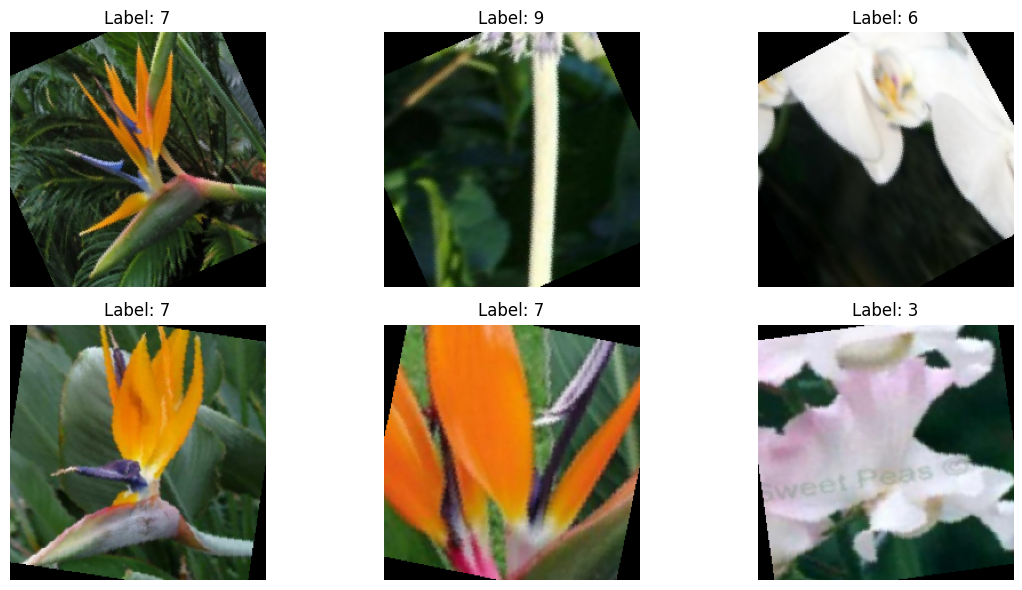

In [11]:
os.makedirs('./data', exist_ok=True)

# Define the data transformations.
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# For validation and testing: only resizing and normalization.
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#dataset splits with transformations applied.
full_train_dataset = datasets.Flowers102(root='./data',
                                           split='train',
                                           transform=train_transform,
                                           download=True)
full_val_dataset = datasets.Flowers102(root='./data',
                                         split='val',
                                         transform=val_test_transform,
                                         download=True)
full_test_dataset = datasets.Flowers102(root='./data',
                                          split='test',
                                          transform=val_test_transform,
                                          download=True)


# classes [0, 1, ..., 9].
subset_classes = set(range(10))  # 10 classes for simplicity

def filter_indices(dataset, subset_classes, max_per_class=None):
    indices = []
    counts = {c: 0 for c in subset_classes}

    for idx, target in enumerate(dataset._labels):
        if target in subset_classes:
            if max_per_class is None or counts[target] < max_per_class:
                indices.append(idx)
                counts[target] += 1
    return indices

# Limit images per class if needed
max_images_per_class = None
train_indices = filter_indices(full_train_dataset, subset_classes, max_per_class=max_images_per_class)
val_indices = filter_indices(full_val_dataset, subset_classes, max_per_class=max_images_per_class)
test_indices = filter_indices(full_test_dataset, subset_classes, max_per_class=max_images_per_class)

# Create subset datasets using the filtered indices.
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_val_dataset, val_indices)
test_dataset = Subset(full_test_dataset, test_indices)


print("Dataset Selection")
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Visualize some sample training images.
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Display 6 sample images.
sample_images, sample_labels = next(iter(train_loader))
fig = plt.figure(figsize=(12, 6))
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    imshow(sample_images[i], f"Label: {sample_labels[i]}")
plt.tight_layout()
plt.show()


# Model Selection and Architecture

In [12]:
# Define a simple CNN architecture for image classification.

class FlowerCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(FlowerCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # After four pooling layers with input size 224x224:
        # Feature map size = 224 / (2^4) = 14 x 14.
        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features.
        x = self.classifier(x)
        return x

# Initialize the model and move to device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerCNN(num_classes=10).to(device)
print("Model Architecture")
print(model)

Model Architecture
FlowerCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5

# Model Training

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5, device='cpu'):
    best_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            progress_bar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)

        # Validation phase.
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Early stopping check.
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Validation loss improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    return train_losses, val_losses, val_accuracies

# Set loss criterion and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Starting Model Training")
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer,
                                                       num_epochs=50, patience=5, device=device)

Starting Model Training


Epoch 1/50: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s, loss=2.39]


Epoch 1/50: Train Loss: 2.3215, Train Acc: 0.1000, Val Loss: 2.2840, Val Acc: 0.2300
Validation loss improved. Model saved.


Epoch 2/50: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s, loss=2.26]


Epoch 2/50: Train Loss: 2.2775, Train Acc: 0.1800, Val Loss: 2.2500, Val Acc: 0.1900
Validation loss improved. Model saved.


Epoch 3/50: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, loss=2.4]


Epoch 3/50: Train Loss: 2.2362, Train Acc: 0.2000, Val Loss: 2.1701, Val Acc: 0.3000
Validation loss improved. Model saved.


Epoch 4/50: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s, loss=1.89]


Epoch 4/50: Train Loss: 2.1439, Train Acc: 0.3200, Val Loss: 2.0347, Val Acc: 0.3800
Validation loss improved. Model saved.


Epoch 5/50: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s, loss=1.86]


Epoch 5/50: Train Loss: 2.0036, Train Acc: 0.2800, Val Loss: 1.9070, Val Acc: 0.3400
Validation loss improved. Model saved.


Epoch 6/50: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s, loss=1.76]


Epoch 6/50: Train Loss: 1.8817, Train Acc: 0.3100, Val Loss: 1.7350, Val Acc: 0.4100
Validation loss improved. Model saved.


Epoch 7/50: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, loss=1.89]


Epoch 7/50: Train Loss: 1.7312, Train Acc: 0.3800, Val Loss: 1.6762, Val Acc: 0.4400
Validation loss improved. Model saved.


Epoch 8/50: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, loss=1.25]


Epoch 8/50: Train Loss: 1.7259, Train Acc: 0.3900, Val Loss: 1.6097, Val Acc: 0.4200
Validation loss improved. Model saved.


Epoch 9/50: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s, loss=1.72]


Epoch 9/50: Train Loss: 1.6348, Train Acc: 0.4000, Val Loss: 1.6252, Val Acc: 0.4200
No improvement in validation loss for 1 epoch(s).


Epoch 10/50: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, loss=1.4]


Epoch 10/50: Train Loss: 1.6620, Train Acc: 0.3600, Val Loss: 1.5366, Val Acc: 0.4700
Validation loss improved. Model saved.


Epoch 11/50: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, loss=0.797]


Epoch 11/50: Train Loss: 1.6171, Train Acc: 0.4300, Val Loss: 1.5067, Val Acc: 0.4300
Validation loss improved. Model saved.


Epoch 12/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s, loss=1.19]


Epoch 12/50: Train Loss: 1.5846, Train Acc: 0.3700, Val Loss: 1.5088, Val Acc: 0.4900
No improvement in validation loss for 1 epoch(s).


Epoch 13/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s, loss=2.28]


Epoch 13/50: Train Loss: 1.4820, Train Acc: 0.4500, Val Loss: 1.4672, Val Acc: 0.4700
Validation loss improved. Model saved.


Epoch 14/50: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, loss=1.82]


Epoch 14/50: Train Loss: 1.5348, Train Acc: 0.4500, Val Loss: 1.4086, Val Acc: 0.4900
Validation loss improved. Model saved.


Epoch 15/50: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, loss=2]


Epoch 15/50: Train Loss: 1.4672, Train Acc: 0.4100, Val Loss: 1.3988, Val Acc: 0.4800
Validation loss improved. Model saved.


Epoch 16/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, loss=0.845]


Epoch 16/50: Train Loss: 1.3897, Train Acc: 0.4600, Val Loss: 1.4062, Val Acc: 0.5000
No improvement in validation loss for 1 epoch(s).


Epoch 17/50: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, loss=1.05]


Epoch 17/50: Train Loss: 1.4187, Train Acc: 0.4900, Val Loss: 1.3226, Val Acc: 0.5100
Validation loss improved. Model saved.


Epoch 18/50: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, loss=1.27]


Epoch 18/50: Train Loss: 1.4786, Train Acc: 0.4700, Val Loss: 1.2919, Val Acc: 0.5100
Validation loss improved. Model saved.


Epoch 19/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s, loss=2.19]


Epoch 19/50: Train Loss: 1.4955, Train Acc: 0.4600, Val Loss: 1.3474, Val Acc: 0.4900
No improvement in validation loss for 1 epoch(s).


Epoch 20/50: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, loss=1.37]


Epoch 20/50: Train Loss: 1.4386, Train Acc: 0.4700, Val Loss: 1.3965, Val Acc: 0.5100
No improvement in validation loss for 2 epoch(s).


Epoch 21/50: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, loss=0.796]


Epoch 21/50: Train Loss: 1.3500, Train Acc: 0.4400, Val Loss: 1.3685, Val Acc: 0.5800
No improvement in validation loss for 3 epoch(s).


Epoch 22/50: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s, loss=1.65]


Epoch 22/50: Train Loss: 1.2899, Train Acc: 0.5400, Val Loss: 1.2866, Val Acc: 0.5900
Validation loss improved. Model saved.


Epoch 23/50: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, loss=1.15]


Epoch 23/50: Train Loss: 1.4200, Train Acc: 0.4300, Val Loss: 1.2153, Val Acc: 0.5900
Validation loss improved. Model saved.


Epoch 24/50: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s, loss=1.9]


Epoch 24/50: Train Loss: 1.3427, Train Acc: 0.5400, Val Loss: 1.3144, Val Acc: 0.5200
No improvement in validation loss for 1 epoch(s).


Epoch 25/50: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, loss=0.99]


Epoch 25/50: Train Loss: 1.1237, Train Acc: 0.5700, Val Loss: 1.3481, Val Acc: 0.5900
No improvement in validation loss for 2 epoch(s).


Epoch 26/50: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s, loss=1.12]


Epoch 26/50: Train Loss: 1.2717, Train Acc: 0.5200, Val Loss: 1.3559, Val Acc: 0.5900
No improvement in validation loss for 3 epoch(s).


Epoch 27/50: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, loss=1.37]


Epoch 27/50: Train Loss: 1.2332, Train Acc: 0.6100, Val Loss: 1.4065, Val Acc: 0.4400
No improvement in validation loss for 4 epoch(s).


Epoch 28/50: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, loss=0.407]


Epoch 28/50: Train Loss: 1.1707, Train Acc: 0.6100, Val Loss: 1.0746, Val Acc: 0.6600
Validation loss improved. Model saved.


Epoch 29/50: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, loss=1.42]


Epoch 29/50: Train Loss: 1.1613, Train Acc: 0.5900, Val Loss: 1.1308, Val Acc: 0.5900
No improvement in validation loss for 1 epoch(s).


Epoch 30/50: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s, loss=2]


Epoch 30/50: Train Loss: 1.1272, Train Acc: 0.6200, Val Loss: 1.0886, Val Acc: 0.6000
No improvement in validation loss for 2 epoch(s).


Epoch 31/50: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s, loss=1.58]


Epoch 31/50: Train Loss: 1.1756, Train Acc: 0.5400, Val Loss: 1.4563, Val Acc: 0.4300
No improvement in validation loss for 3 epoch(s).


Epoch 32/50: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s, loss=0.842]


Epoch 32/50: Train Loss: 1.2527, Train Acc: 0.5600, Val Loss: 1.0715, Val Acc: 0.5800
Validation loss improved. Model saved.


Epoch 33/50: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, loss=0.791]


Epoch 33/50: Train Loss: 0.9652, Train Acc: 0.6700, Val Loss: 1.0584, Val Acc: 0.6300
Validation loss improved. Model saved.


Epoch 34/50: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s, loss=0.418]


Epoch 34/50: Train Loss: 1.0447, Train Acc: 0.6300, Val Loss: 1.1474, Val Acc: 0.6400
No improvement in validation loss for 1 epoch(s).


Epoch 35/50: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, loss=1.1]


Epoch 35/50: Train Loss: 1.0503, Train Acc: 0.6500, Val Loss: 1.0611, Val Acc: 0.6500
No improvement in validation loss for 2 epoch(s).


Epoch 36/50: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s, loss=1.01]


Epoch 36/50: Train Loss: 1.0279, Train Acc: 0.6100, Val Loss: 0.9284, Val Acc: 0.6700
Validation loss improved. Model saved.


Epoch 37/50: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s, loss=1.23]


Epoch 37/50: Train Loss: 0.9328, Train Acc: 0.6300, Val Loss: 0.9382, Val Acc: 0.6500
No improvement in validation loss for 1 epoch(s).


Epoch 38/50: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, loss=0.524]


Epoch 38/50: Train Loss: 1.0446, Train Acc: 0.6100, Val Loss: 1.2293, Val Acc: 0.5300
No improvement in validation loss for 2 epoch(s).


Epoch 39/50: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, loss=2]


Epoch 39/50: Train Loss: 1.0850, Train Acc: 0.5900, Val Loss: 1.1318, Val Acc: 0.6300
No improvement in validation loss for 3 epoch(s).


Epoch 40/50: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, loss=1.55]


Epoch 40/50: Train Loss: 1.0802, Train Acc: 0.6100, Val Loss: 1.0582, Val Acc: 0.5800
No improvement in validation loss for 4 epoch(s).


Epoch 41/50: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, loss=0.734]


Epoch 41/50: Train Loss: 1.0099, Train Acc: 0.6300, Val Loss: 0.9660, Val Acc: 0.7000
No improvement in validation loss for 5 epoch(s).
Early stopping triggered!


# Evaluation on Validation Dataset

Q5: Evaluation on Validation Dataset
Validation Accuracy: 0.7000
Classification Report:
              precision    recall  f1-score   support

           0     0.5833    0.7000    0.6364        10
           1     0.6000    0.9000    0.7200        10
           2     1.0000    0.2000    0.3333        10
           3     0.5000    0.1000    0.1667        10
           4     0.8889    0.8000    0.8421        10
           5     0.7778    0.7000    0.7368        10
           6     0.9000    0.9000    0.9000        10
           7     0.6364    0.7000    0.6667        10
           8     0.5882    1.0000    0.7407        10
           9     0.7692    1.0000    0.8696        10

    accuracy                         0.7000       100
   macro avg     0.7244    0.7000    0.6612       100
weighted avg     0.7244    0.7000    0.6612       100



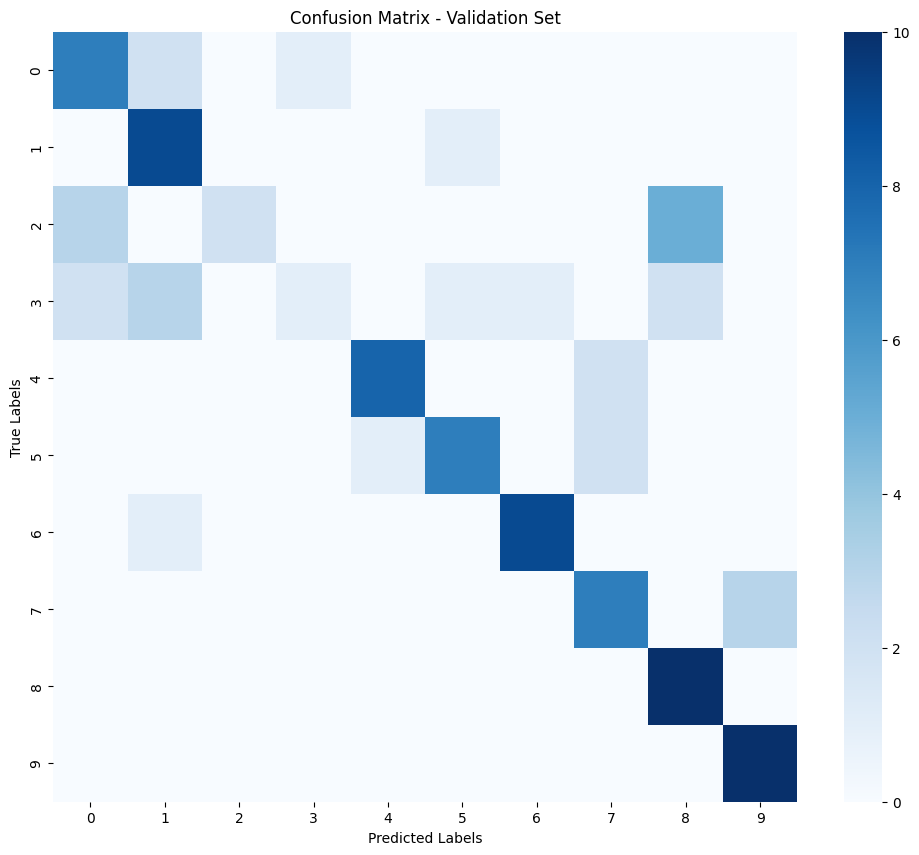

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


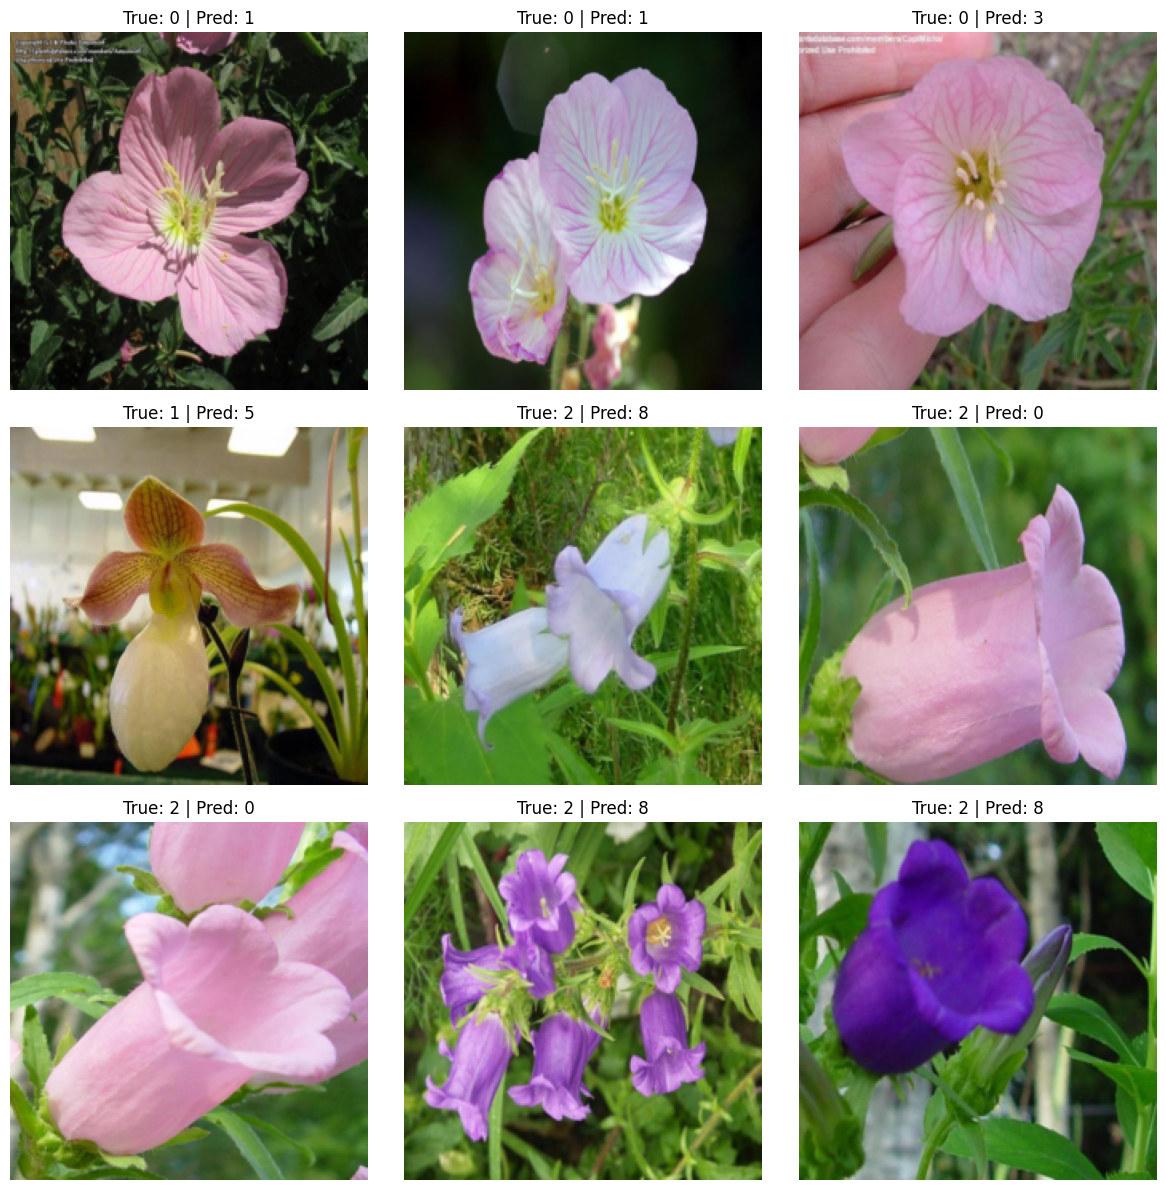

In [14]:
def evaluate_model(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)
    cm = confusion_matrix(y_true, y_pred)

    print("Q5: Evaluation on Validation Dataset")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
    plt.title("Confusion Matrix - Validation Set")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Visualize misclassified examples.
    misclassified_images = []
    misclassified_true = []
    misclassified_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified_images.append(images[i].cpu())
                    misclassified_true.append(labels[i].cpu().item())
                    misclassified_pred.append(preds[i].cpu().item())
            if len(misclassified_images) >= 9:
                break

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if i < len(misclassified_images):
            img = misclassified_images[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std  = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(f"True: {misclassified_true[i]} | Pred: {misclassified_pred[i]}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

evaluate_model(model, val_loader, device)

#Fine-Tuning and Iteration

In [15]:
def fine_tune_train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5, device='cpu'):
    best_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch+1}/{num_epochs}")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            progress_bar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Fine-tuning Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Step the scheduler based on validation loss.
        scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_finetuned.pth")
            print("Validation loss improved, model saved.")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered during fine-tuning!")
                break

    return train_losses, val_losses, val_accuracies

# Reinitialize optimizer with a lower learning rate for fine-tuning.
optimizer_ft = optim.Adam(model.parameters(), lr=0.00005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3, verbose=True)

print("Fine-Tuning and Iteration")
train_losses_ft, val_losses_ft, val_accuracies_ft = fine_tune_train_model(model, train_loader, val_loader,
                                                                           criterion, optimizer_ft, scheduler,
                                                                           num_epochs=50, patience=5, device=device)

# Load the best fine-tuned model.
model.load_state_dict(torch.load("best_model_finetuned.pth", map_location=device))
print("Fine-tuning complete. Best fine-tuned model loaded.")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fine-Tuning and Iteration


Fine-tuning Epoch 1/50: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s, loss=1.16]


Fine-tuning Epoch 1/50: Train Loss: 0.8915, Val Loss: 1.0294, Val Acc: 0.6500
Validation loss improved, model saved.


Fine-tuning Epoch 2/50: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, loss=1.13]


Fine-tuning Epoch 2/50: Train Loss: 0.8918, Val Loss: 1.0166, Val Acc: 0.6000
Validation loss improved, model saved.


Fine-tuning Epoch 3/50: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, loss=0.814]


Fine-tuning Epoch 3/50: Train Loss: 0.8788, Val Loss: 1.0243, Val Acc: 0.5900
No improvement for 1 epoch(s).


Fine-tuning Epoch 4/50: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, loss=1.11]


Fine-tuning Epoch 4/50: Train Loss: 0.7936, Val Loss: 0.9633, Val Acc: 0.5900
Validation loss improved, model saved.


Fine-tuning Epoch 5/50: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s, loss=2.15]


Fine-tuning Epoch 5/50: Train Loss: 0.9095, Val Loss: 0.9585, Val Acc: 0.6300
Validation loss improved, model saved.


Fine-tuning Epoch 6/50: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s, loss=1.39]


Fine-tuning Epoch 6/50: Train Loss: 0.8561, Val Loss: 0.9107, Val Acc: 0.6900
Validation loss improved, model saved.


Fine-tuning Epoch 7/50: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s, loss=0.382]


Fine-tuning Epoch 7/50: Train Loss: 0.8382, Val Loss: 0.9706, Val Acc: 0.6400
No improvement for 1 epoch(s).


Fine-tuning Epoch 8/50: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, loss=1.39]


Fine-tuning Epoch 8/50: Train Loss: 0.8448, Val Loss: 1.0048, Val Acc: 0.6300
No improvement for 2 epoch(s).


Fine-tuning Epoch 9/50: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, loss=0.314]


Fine-tuning Epoch 9/50: Train Loss: 0.6999, Val Loss: 0.9801, Val Acc: 0.6600
No improvement for 3 epoch(s).


Fine-tuning Epoch 10/50: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, loss=1.12]


Fine-tuning Epoch 10/50: Train Loss: 0.7020, Val Loss: 1.0359, Val Acc: 0.6000
No improvement for 4 epoch(s).


Fine-tuning Epoch 11/50: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s, loss=0.474]


Fine-tuning Epoch 11/50: Train Loss: 0.7751, Val Loss: 1.0659, Val Acc: 0.6100
No improvement for 5 epoch(s).
Early stopping triggered during fine-tuning!
Fine-tuning complete. Best fine-tuned model loaded.


#Final Model Testing on Held-Out Test Data

Final Model Testing
Test Loss: 1.0569
Test Accuracy: 0.6739
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    0.4000    0.5333        20
           1     0.7143    0.7500    0.7317        40
           2     0.2000    0.0500    0.0800        20
           3     0.6000    0.4167    0.4918        36
           4     0.9429    0.7333    0.8250        45
           5     0.5122    0.8400    0.6364        25
           6     0.8182    0.9000    0.8571        20
           7     0.8182    0.6923    0.7500        65
           8     0.5102    0.9615    0.6667        26
           9     0.5526    0.8400    0.6667        25

    accuracy                         0.6739       322
   macro avg     0.6469    0.6584    0.6239       322
weighted avg     0.6895    0.6739    0.6589       322



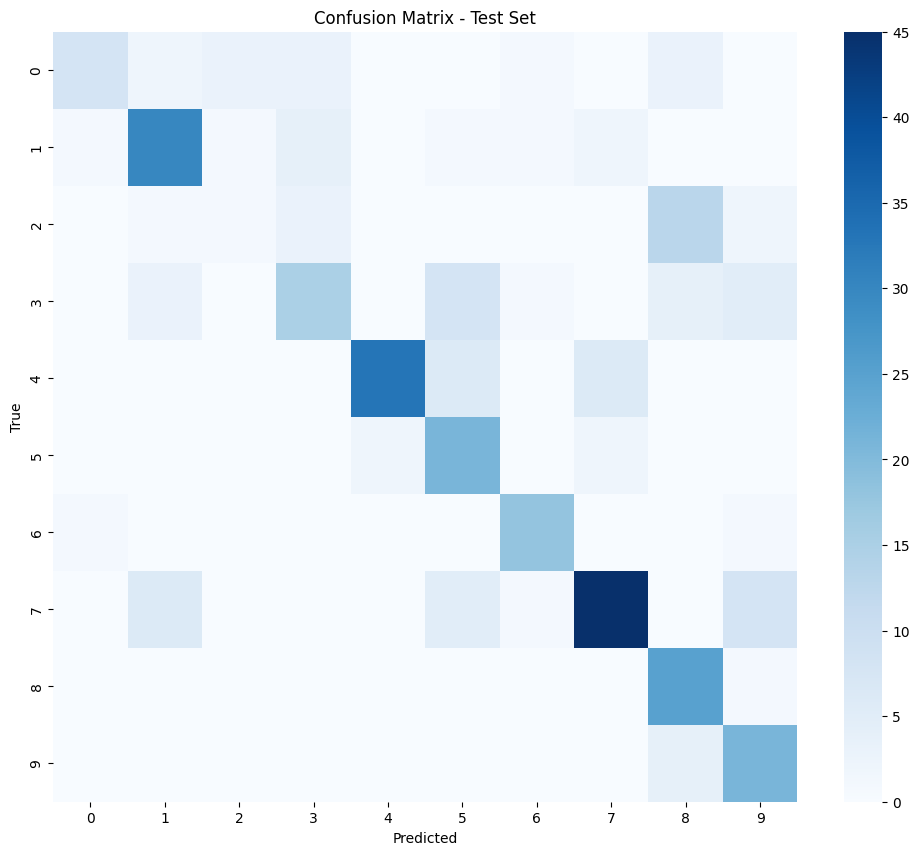

In [16]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct / total

    print("Final Model Testing")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return avg_test_loss, test_accuracy

test_loss, test_accuracy = test_model(model, test_loader, criterion, device)

# Plotting the curves

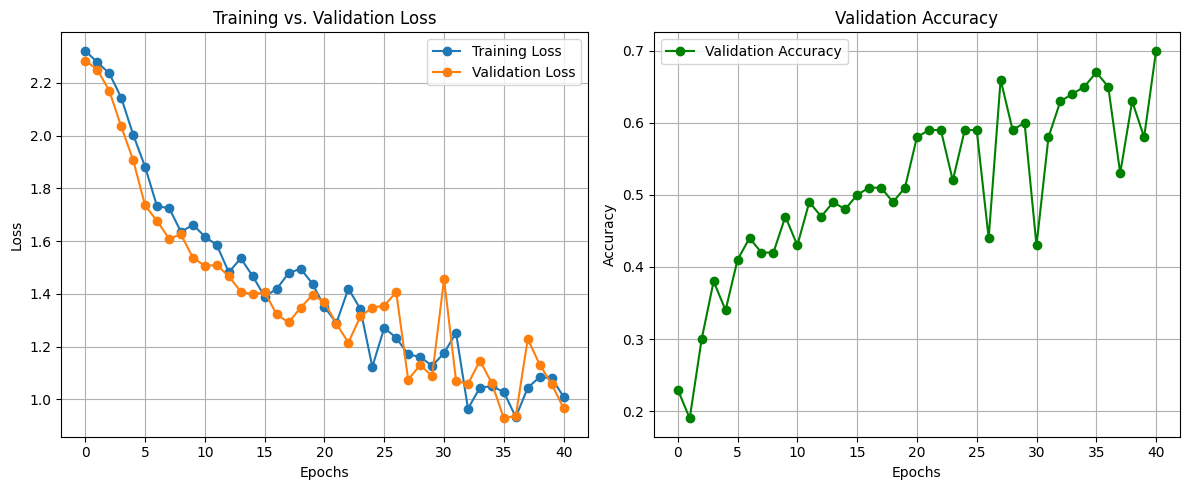

In [17]:

# Plotting the loss curves for both training and validation.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

# Plotting the validation accuracy curve.
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#Advanced Visualization using GradCAM

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


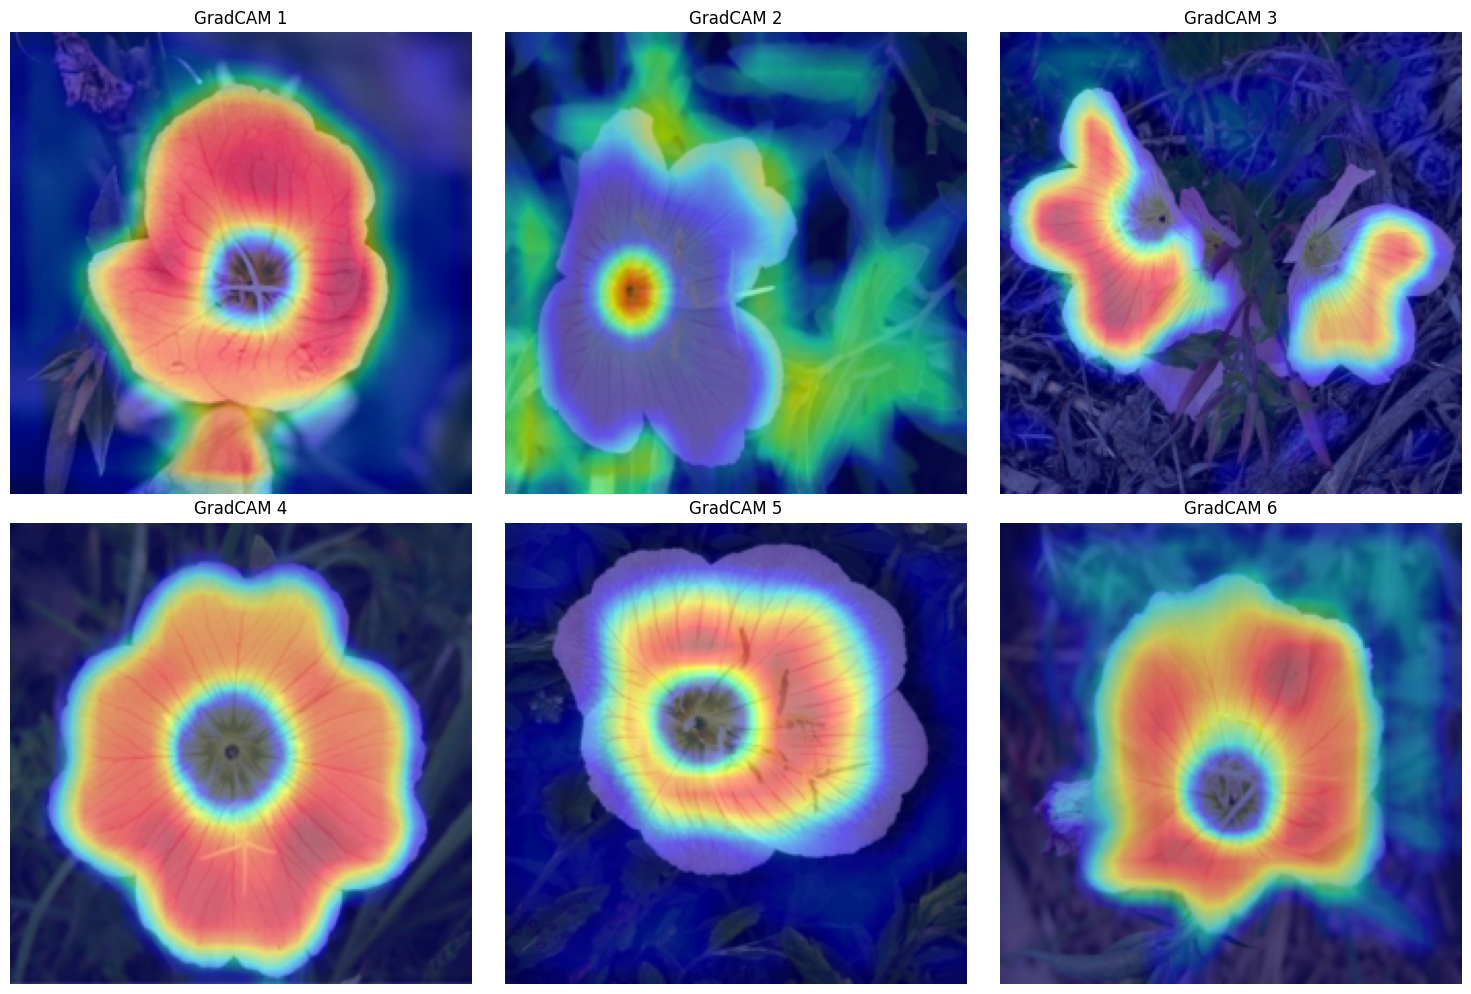

In [18]:

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
        self.hooks.append(self.target_layer.register_forward_hook(self.forward_hook))
        self.hooks.append(self.target_layer.register_backward_hook(self.backward_hook))

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        loss = output[0, target_class]
        loss.backward()

        gradients = self.gradients[0]      # [C, h, w]
        activations = self.activations[0]  # [C, h, w]
        weights = torch.mean(gradients, dim=(1,2))  # [C]

        cam = torch.zeros(activations.shape[1:], device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        cam = F.relu(cam)
        cam -= cam.min()
        if cam.max() != 0:
            cam /= cam.max()

        # Upsample the heatmap to match the input image size
        cam = cam.unsqueeze(0).unsqueeze(0)  # shape: [1, 1, h, w]
        cam = F.interpolate(cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
        cam = cam.squeeze()  # shape: [H, W]
        return cam.cpu().numpy()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

def show_gradcam_grid(model, test_loader, device, num_images=6):
    model.eval()
    # Get one batch from the test loader and move it to the device
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images.to(device)

    # Use a target convolutional layer.
    target_layer = model.features[-3]
    gradcam = GradCAM(model, target_layer)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    for i in range(num_images):
        input_image = images[i].unsqueeze(0)
        cam = gradcam.generate(input_image)

        # De-normalize the image for visualization
        img_np = input_image.squeeze().cpu().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        axes[i].imshow(img_np)
        axes[i].imshow(cam, cmap='jet', alpha=0.5)
        axes[i].set_title(f"GradCAM {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()
    gradcam.remove_hooks()


show_gradcam_grid(model, test_loader, device, num_images=6)
